In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import scipy.stats
from sklearn.cluster import KMeans, DBSCAN, Birch, AgglomerativeClustering
from sklearn.metrics import silhouette_score


np.random.seed(0)

# Experimenting with Clustering: Dry Bean Dataset

In [2]:
bean_df = pd.read_excel("DryBeanDataset/Dry_Bean_Dataset.xlsx")
bean_df = bean_df.astype({'Class':'category'})
bean_df

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,42097,759.696,288.721612,185.944705,1.552728,0.765002,42508,231.515799,0.714574,0.990331,0.916603,0.801865,0.006858,0.001749,0.642988,0.998385,DERMASON
13607,42101,757.499,281.576392,190.713136,1.476439,0.735702,42494,231.526798,0.799943,0.990752,0.922015,0.822252,0.006688,0.001886,0.676099,0.998219,DERMASON
13608,42139,759.321,281.539928,191.187979,1.472582,0.734065,42569,231.631261,0.729932,0.989899,0.918424,0.822730,0.006681,0.001888,0.676884,0.996767,DERMASON
13609,42147,763.779,283.382636,190.275731,1.489326,0.741055,42667,231.653248,0.705389,0.987813,0.907906,0.817457,0.006724,0.001852,0.668237,0.995222,DERMASON


## Exploratory Data Analysis

/var/folders/2s/ljy97kw93v37224p__wn8n780001d6/T/ipykernel_73336/4001671066.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i,j].set_xticklabels(feature.unique(),rotation=-30)


,Column,Mean,Median,Standard Deviation,Min,Max
0,Area,53048.284549,44652.000000,29323.018477,20420,254616
1,Perimeter,855.283459,794.941000,214.281824,524.736,1985.37
2,MajorAxisLength,320.141867,296.883367,85.691038,183.601165,738.860153
3,MinorAxisLength,202.270714,192.431733,44.968439,122.512653,460.198497
4,AspectRation,1.583242,1.551124,0.246669,1.024868,2.430306
5,Eccentricity,0.750895,0.764441,0.091998,0.218951,0.911423
6,ConvexArea,53768.200206,45178.000000,29773.822016,20684,263261
7,EquivDiameter,253.064220,238.438026,59.174946,161.243764,569.374358
8,Extent,0.749733,0.759859,0.049085,0.555315,0.866195
9,Solidity,0.987143,0.988283,0.004660,0.919246,0.994677


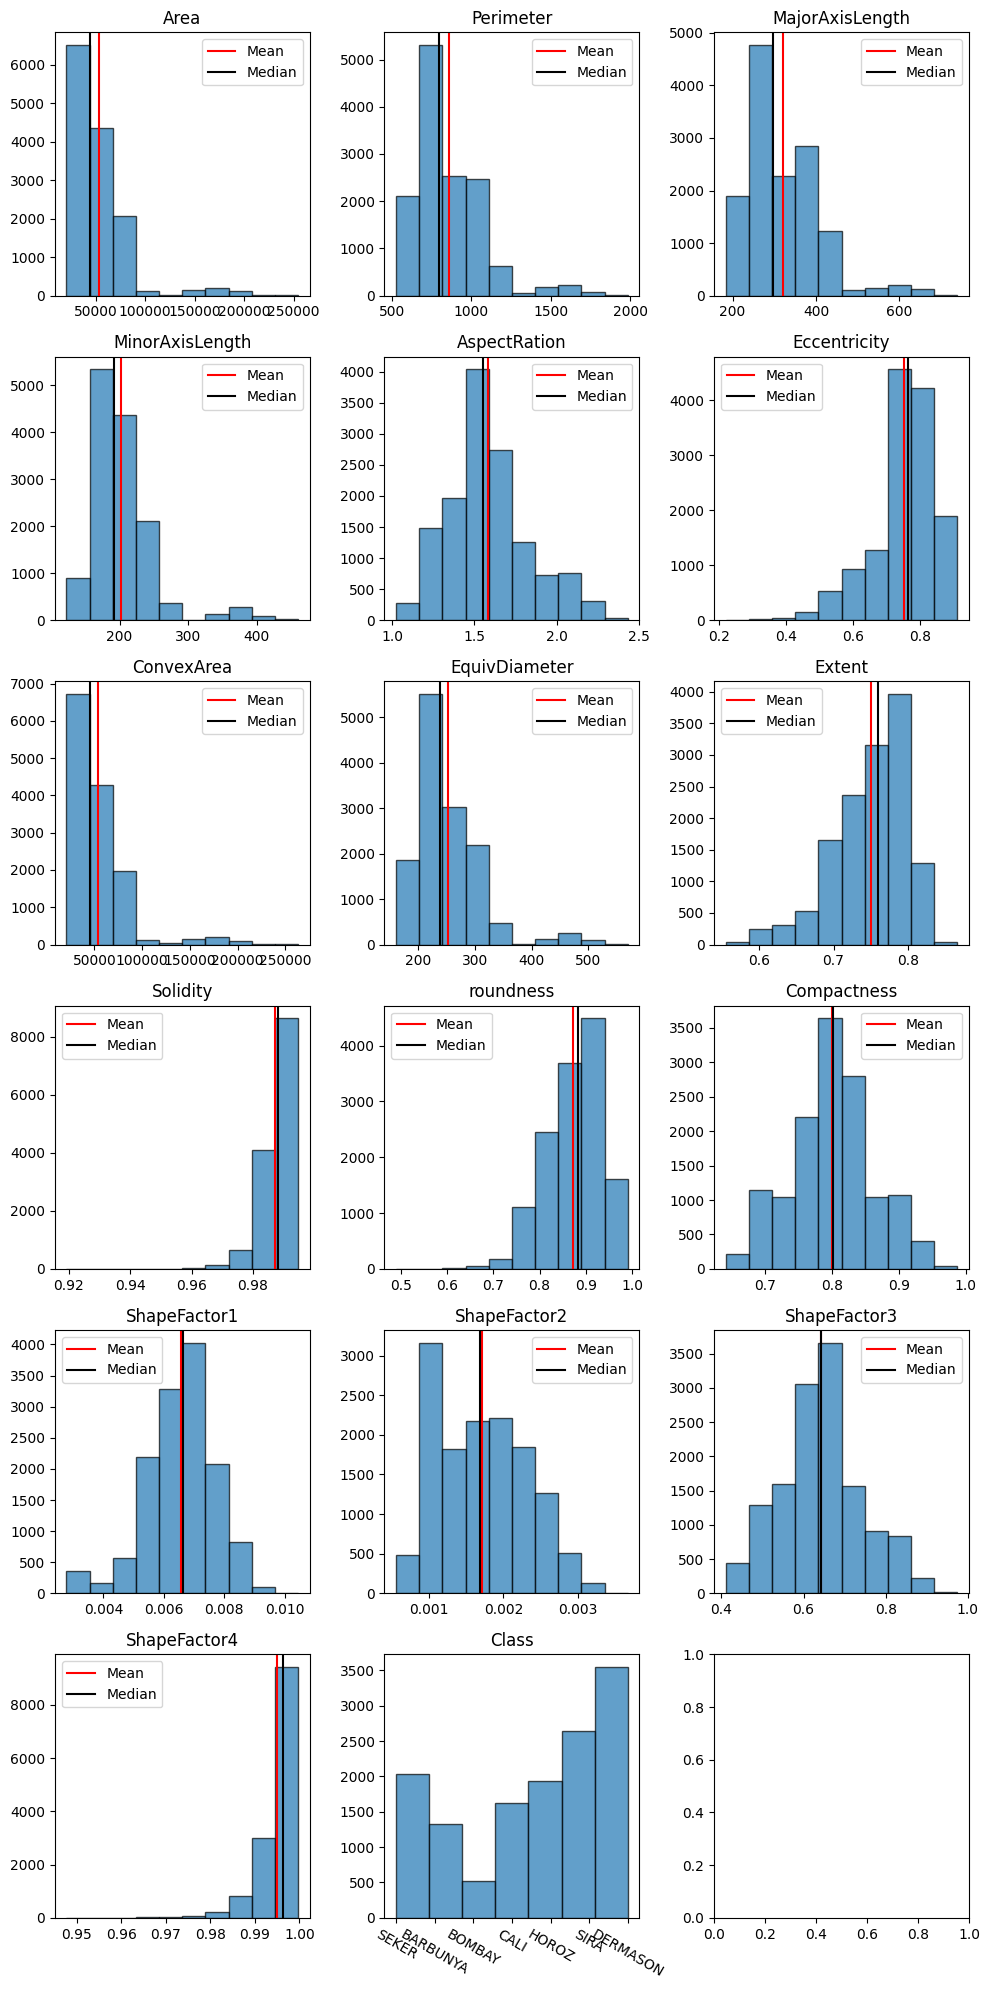

In [3]:
cols = np.array(bean_df.columns)
count=0

col_df = pd.DataFrame(columns=[['Column','Mean','Median', 'Standard Deviation', 'Min', 'Max']])

fig, ax = plt.subplots(6,3,figsize=(10,20),dpi=100)
for i,col in enumerate(ax):
    for j, row in enumerate(col):
        try:
            feature = bean_df[cols[count]]
            feature_arr = np.array(feature)
            #print(cols[count],np.mean(feature_arr))
            if (feature.dtype=='int64') or (feature.dtype=='float64'):
                col_df.loc[len(col_df.index)] = [cols[count], np.mean(feature_arr),np.median(feature_arr),np.std(feature_arr),min(feature_arr),max(feature_arr)]
            ax[i,j].set_title(cols[count])
            if feature.dtype.name == 'category':
                ax[i,j].hist(feature_arr,bins=len(feature.unique()),ec='k',alpha=0.7)
                ax[i,j].set_xticklabels(feature.unique(),rotation=-30)
                
            else:
                ax[i,j].hist(feature_arr,ec='k',alpha=0.7)
                ax[i,j].axvline(np.mean(feature_arr),label='Mean',color='r')
                ax[i,j].axvline(np.median(feature_arr),label='Median',color='k')
                ax[i,j].legend()
            count+=1
        except IndexError:
            pass

plt.tight_layout()
plt.savefig("feature_hist.png")
col_df

Area, Perimeter, MajorAxisLength, MinorAxisLength, ConvexArea, and EquivDiameter all likely need to be scaled down to values on order of 1 to not have inflated weighting in any classification scheme. Several distributions have clusters far away from the main peak, possibly one or several of the bean types is significantly different than the rest in those factors? Class is fairly evenly distributed, but have a small sample size for Bombay (roughly 500). Largest sample is Dermason (roughly 3500).

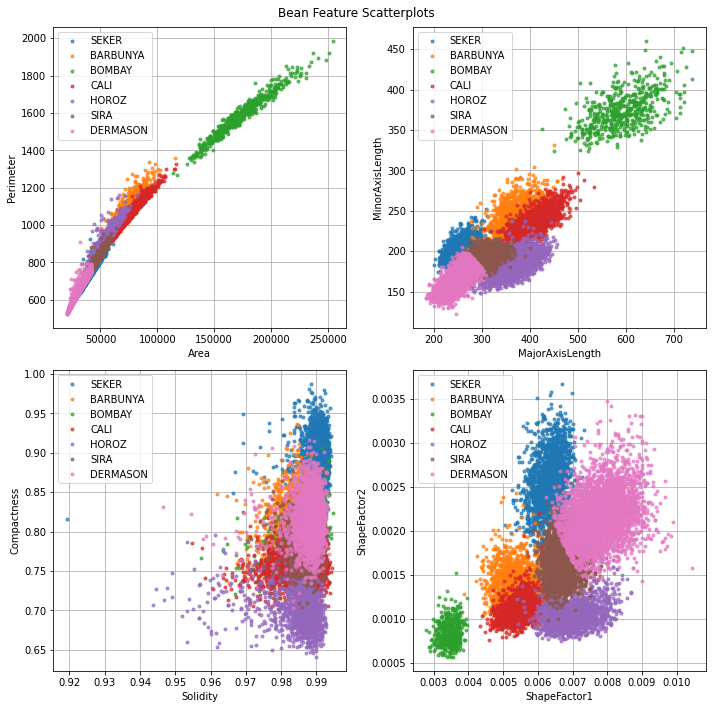

In [4]:
#See the distribution of each bean type for a few features

fig, ax = plt.subplots(2,2,figsize=(10,10))

beans = bean_df['Class'].unique()
grouped_df = bean_df.groupby('Class')

comps = [('Area','Perimeter'),('MajorAxisLength','MinorAxisLength'),('Solidity','Compactness'),('ShapeFactor1','ShapeFactor2')] #For specific comparisons
count=0
for i, col in enumerate(ax):
    for j, row in enumerate(col):
        for bean in beans:
            group_df = grouped_df.get_group(bean)
            comp = comps[count]
            row.plot(group_df[comp[0]],group_df[comp[1]],'.',label=bean,alpha=0.7)
        count+=1
        row.legend()
        row.grid()
        row.set_xlabel(comp[0])
        row.set_ylabel(comp[1])
fig.suptitle('Bean Feature Scatterplots')
plt.tight_layout()
plt.savefig("feature_scatter.png")   

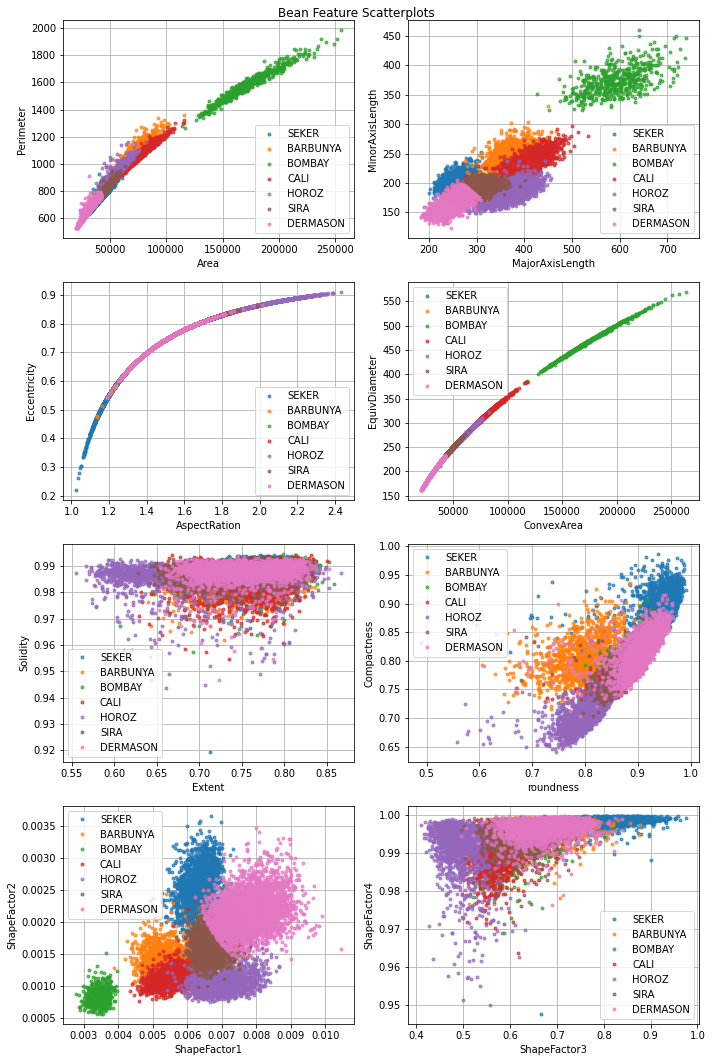

In [5]:
#See the distribution of each bean type for all features

fig, ax = plt.subplots(4,2,figsize=(10,15))

beans = bean_df['Class'].unique()
grouped_df = bean_df.groupby('Class')

count=0
for i, col in enumerate(ax):
    for j, row in enumerate(col):
        for bean in beans:
            group_df = grouped_df.get_group(bean)
            comp = (bean_df.columns[count],bean_df.columns[count+1])
            #print(comp)
            row.plot(group_df[comp[0]],group_df[comp[1]],'.',label=bean,alpha=0.7)
        count+=2
        row.legend()
        row.grid()
        row.set_xlabel(comp[0])
        row.set_ylabel(comp[1])
fig.suptitle('Bean Feature Scatterplots')
plt.tight_layout()

From plots of the features, we can make a few observations:

* Bombay beans are clearly larger than the rest of the bean types, as they stand out distinctly in several plots
* The rest of the bean types are more tightly clustered, but in several plots do see intuitive cluster separation between them, indicating that this dataset is well suited for classification
* In some plots, see tight relationships between the features. Since these features largely describe shape and size, it makes sense that these features will have a degree of intercorrelation (eg area vs diameter, etc.)

## Preprocessing

In [6]:
# Scale several features down using z-scaling

features_to_scale =['Area','Perimeter','MajorAxisLength','MinorAxisLength','ConvexArea','EquivDiameter']

#z-score normalization
zscore_df = bean_df.copy(deep=True)
for col in zscore_df.columns:
    if col in features_to_scale:
        arr = np.array(zscore_df[col])
        arrmean = np.mean(arr)
        arrstd = np.std(arr)

        zscore_df[col] = (arr-arrmean)/(arrstd)

In [7]:
zscore_df

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,-0.840749,-1.143319,-1.306598,-0.631153,1.197191,0.549812,-0.841451,-1.063341,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,-0.829188,-1.013924,-1.395911,-0.434445,1.097356,0.411785,-0.826102,-1.044217,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,-0.807157,-1.078829,-1.252357,-0.585735,1.209713,0.562727,-0.808704,-1.008084,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,-0.785741,-0.977215,-1.278825,-0.439290,1.153638,0.498616,-0.773975,-0.973337,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,-0.781239,-1.097384,-1.380471,-0.266663,1.060798,0.333680,-0.784286,-0.966080,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,-0.373471,-0.446083,-0.366669,-0.363055,1.552728,0.765002,-0.378191,-0.364148,0.714574,0.990331,0.916603,0.801865,0.006858,0.001749,0.642988,0.998385,DERMASON
13607,-0.373334,-0.456336,-0.450053,-0.257015,1.476439,0.735702,-0.378662,-0.363962,0.799943,0.990752,0.922015,0.822252,0.006688,0.001886,0.676099,0.998219,DERMASON
13608,-0.372038,-0.447833,-0.450478,-0.246456,1.472582,0.734065,-0.376143,-0.362197,0.729932,0.989899,0.918424,0.822730,0.006681,0.001888,0.676884,0.996767,DERMASON
13609,-0.371765,-0.427029,-0.428974,-0.266742,1.489326,0.741055,-0.372851,-0.361825,0.705389,0.987813,0.907906,0.817457,0.006724,0.001852,0.668237,0.995222,DERMASON


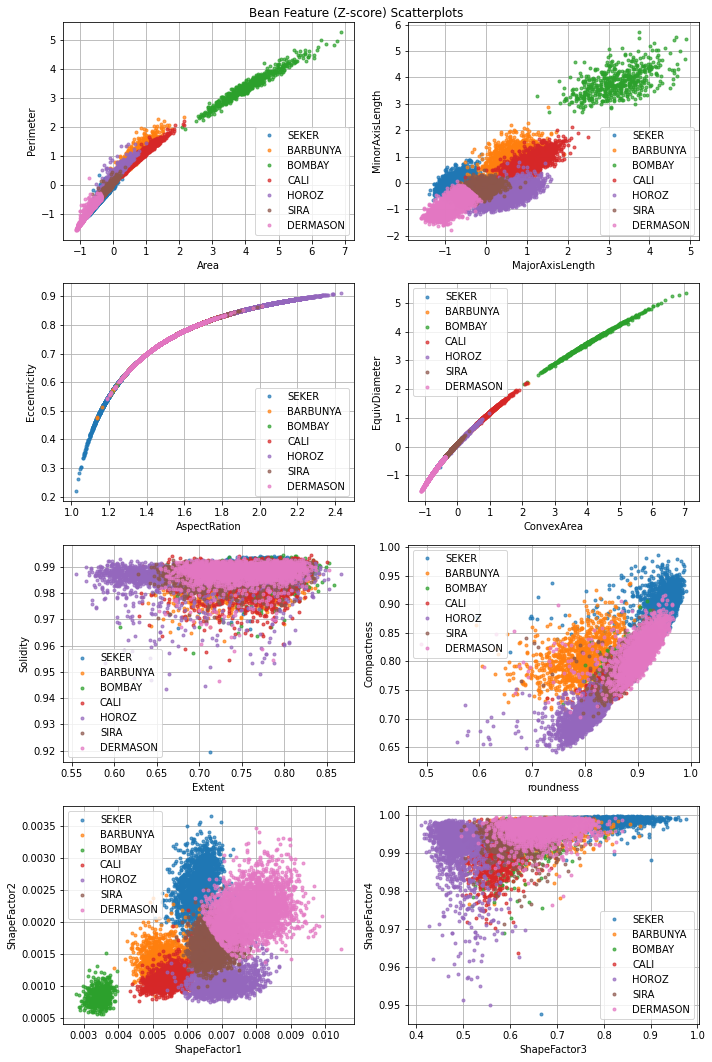

In [8]:
#See the distribution of each bean type for all features

fig, ax = plt.subplots(4,2,figsize=(10,15))

beans = zscore_df['Class'].unique()
grouped_df = zscore_df.groupby('Class')

count=0
for i, col in enumerate(ax):
    for j, row in enumerate(col):
        for bean in beans:
            group_df = grouped_df.get_group(bean)
            comp = (bean_df.columns[count],bean_df.columns[count+1])
            #print(comp)
            row.plot(group_df[comp[0]],group_df[comp[1]],'.',label=bean,alpha=0.7)
        count+=2
        row.legend()
        row.grid()
        row.set_xlabel(comp[0])
        row.set_ylabel(comp[1])
fig.suptitle('Bean Feature (Z-score) Scatterplots')
plt.tight_layout()
plt.savefig("feature_scatter_zscore.png")

## Clustering

### Reduced Dataset
The goal of this experiment will be to see how well we can return the true bean classes given the natural clusters that occur in the data. The dimensionality of this dataset is high, and in the interest of testing clustering algorithms I will be isolating just two features to attempt clustering. The two features I have chosen are ShapeFactor1 and ShapeFactor2, which visually have distinct clusters with a degree of overlap. One goal of the test will be to see how different algorithms handle the cluster entanglement

In [14]:
#Produce the Reduced Dataset
cluster_df = zscore_df[['ShapeFactor1','ShapeFactor2']]

cluster_df

,ShapeFactor1,ShapeFactor2
0,0.007332,0.003147
1,0.006979,0.003564
2,0.007244,0.003048
3,0.007017,0.003215
4,0.006697,0.003665
...,...,...
13606,0.006858,0.001749
13607,0.006688,0.001886
13608,0.006681,0.001888
13609,0.006724,0.001852


### Clustering Model 1: K-Means
Partition-Based Clustering

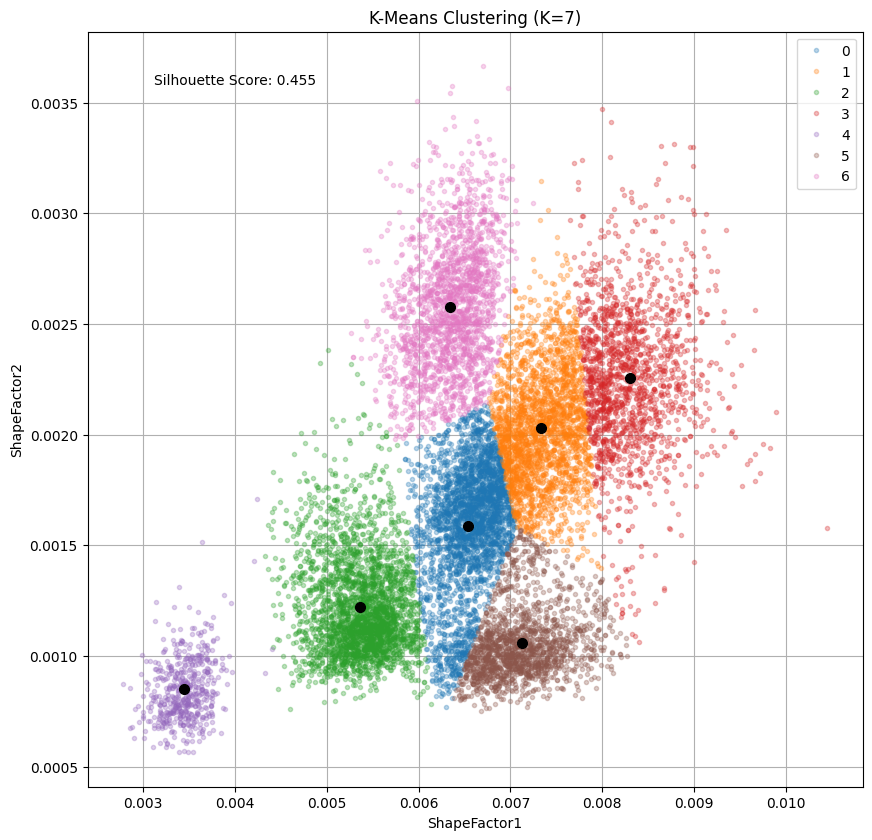

In [190]:
#Define Clustering Algorithm and train
kmeans = KMeans(n_clusters=7,random_state=0)
kmeans.fit(cluster_df)

plt.figure(figsize=(10,10),dpi=100)
plt.title("K-Means Clustering (K=7)")
plt.ylabel("ShapeFactor2")
plt.xlabel("ShapeFactor1")
for cluster in set(kmeans.labels_):
    clust_mask = np.where(kmeans.labels_ == cluster)[0]
    clust_dat = np.array(cluster_df)[clust_mask]
    plt.plot(clust_dat.T[0],clust_dat.T[1],'.',alpha=0.3, label = cluster)
    
for center in kmeans.cluster_centers_:
    plt.plot(center[0],center[1],'o',color='k', markersize=7)
    
plt.legend()
plt.grid()

score = silhouette_score(cluster_df,kmeans.labels_)
plt.text(0.004, 0.0036, "Silhouette Score: "+str(np.round(score,3)), horizontalalignment='center',verticalalignment='center')

plt.savefig("kmeans_result.png")

### Clustering Model 2: DBSCAN
Density-Based Clustering

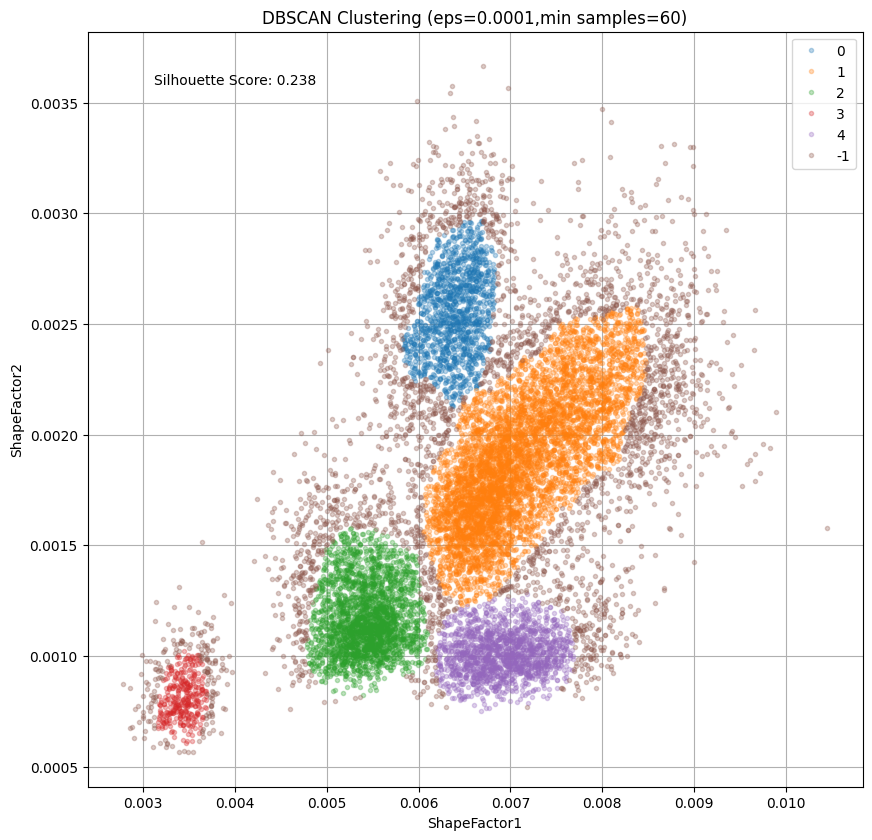

In [191]:
#Define Clustering Algorithm and train
dbscan = DBSCAN(eps=0.0001,min_samples=60)
dbscan.fit(cluster_df)

plt.figure(figsize=(10,10),dpi=100)
plt.title("DBSCAN Clustering (eps=0.0001,min samples=60)")
plt.ylabel("ShapeFactor2")
plt.xlabel("ShapeFactor1")
for cluster in set(dbscan.labels_):
    clust_mask = np.where(dbscan.labels_ == cluster)[0]
    clust_dat = np.array(cluster_df)[clust_mask]
    plt.plot(clust_dat.T[0],clust_dat.T[1],'.',alpha=0.3, label = cluster)
    
#for center in dbscan.cluster_centers_:
#    plt.plot(center[0],center[1],'o',color='k', markersize=7)
    
plt.legend()
plt.grid()

score = silhouette_score(cluster_df,dbscan.labels_)
plt.text(0.004, 0.0036, "Silhouette Score: "+str(np.round(score,3)), horizontalalignment='center',verticalalignment='center')

plt.savefig("dbscan_result.png")

### Clustering Model 3: Agglomerative Clustering
Hierarchical Clustering

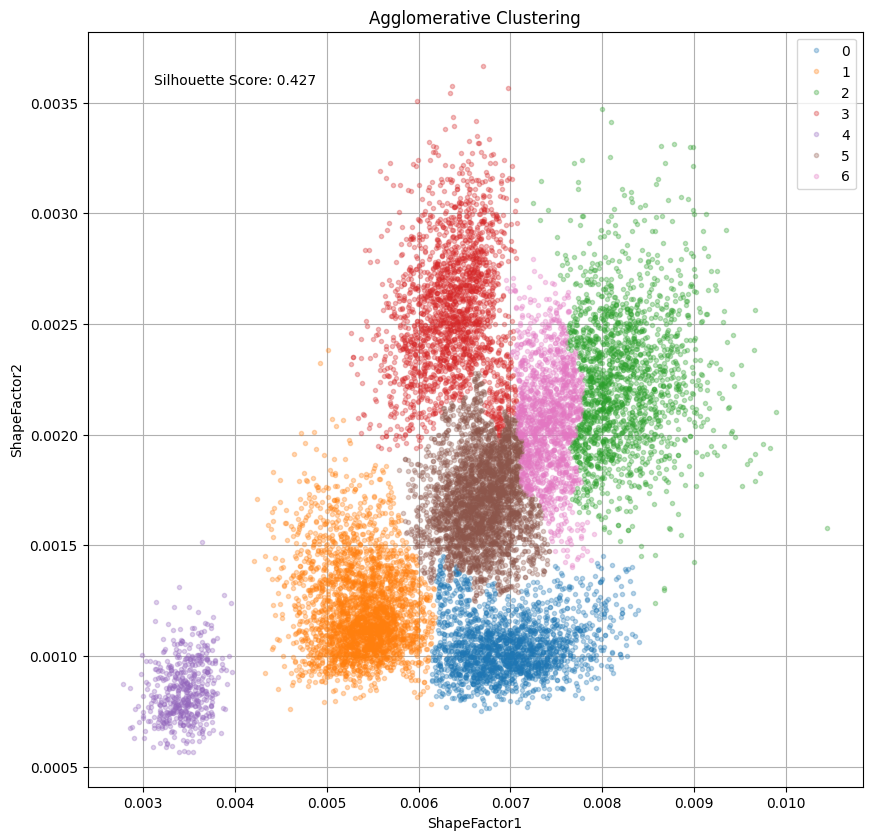

In [192]:
#Define Clustering Algorithm and train
agg = AgglomerativeClustering(n_clusters=7,linkage='ward')
agg.fit(cluster_df)

plt.figure(figsize=(10,10),dpi=100)
plt.title("Agglomerative Clustering")
plt.ylabel("ShapeFactor2")
plt.xlabel("ShapeFactor1")
for cluster in set(agg.labels_):
    clust_mask = np.where(agg.labels_ == cluster)[0]
    clust_dat = np.array(cluster_df)[clust_mask]
    plt.plot(clust_dat.T[0],clust_dat.T[1],'.',alpha=0.3, label = cluster)
    
#for center in agg.cluster_centers_:
#    plt.plot(center[0],center[1],'o',color='k', markersize=7)
    
plt.legend()
plt.grid()

score = silhouette_score(cluster_df,agg.labels_)
plt.text(0.004, 0.0036, "Silhouette Score: "+str(np.round(score,3)), horizontalalignment='center',verticalalignment='center')

plt.savefig("agglo_result.png")